In [134]:
import torch
import os


class Para:
    feature_column_start_name = 'ep_ratio_ttm' # 'VOL5'
    feature_column_end_name = 'BR' # 'AROON_DOWN'

    feature_num = 22 # 8

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    data_path = 'data/cs_space_1d_rate_20d_2022_pre'
    model_path = 'models/model_c2_p[[0.0, 0.3], [0.7, 1.0]]_b32_lr0.001_d0.5_e500.pth'

    classification_n = 2

    month_num = len(os.listdir(data_path))

para = Para()
print(para.month_num)

30


In [135]:
import numpy as np
import torch
from my_utils.model_class import MLP
import pandas as pd

def insert_predict(df: pd.DataFrame, model_path, out_nums: int, column_name: str) -> pd.DataFrame:

    # 加载模型
    model = MLP(in_nums=para.feature_num, out_nums=out_nums, drop_p=0.5)
    model.load_state_dict(torch.load(model_path, map_location=para.device))
    model = model.to(para.device)

    # 运算
    model.eval()
    predict_tensor = model(torch.Tensor(df.loc[:, para.feature_column_start_name: para.feature_column_end_name].values).to(device=para.device))

    # 插入 predict_tensor 列
    df.insert(loc=0, column='predict_tensor_'+column_name, value=np.nan)
    # 插入 predict_return_bin 列
    df.insert(loc=0, column='predict_return_bin_'+column_name, value=np.nan)

    df['predict_tensor'+'_'+column_name] = predict_tensor.to(device='cpu').detach().numpy().tolist()
    df['predict_return_bin'+'_'+column_name] = predict_tensor.to(device='cpu').detach().numpy().argmax(1)

    return df

In [136]:
import torchmetrics
import time
import matplotlib.pyplot as plt
import torch.nn.functional as F

precision = torchmetrics.Precision(average='none', num_classes=para.classification_n)
time_begin = time.time()

plot_df = pd.DataFrame()

# for i_csv in range(48, 59+1):
# for i_csv in range(0, 2):
for i_csv in range(para.month_num):
    print()
    print('i_csv: {}'.format(i_csv))
    print('use time: {}'.format(time.time() - time_begin))

    df = pd.read_csv(para.data_path +'/' + str(i_csv) + '.csv', index_col='order_book_id')

    # 插入预测数据
    df = insert_predict(df=df, model_path=para.model_path, out_nums=para.classification_n, column_name='2c')

    # 综合多个预测数据
    df.insert(loc=0, column='predict_return_bin', value=np.nan)
    df.loc[df['predict_return_bin_2c'].isin([0,]), 'predict_return_bin'] = 0
    df['predict_return_bin'].replace(to_replace=np.nan, value=1, inplace=True)
    df['predict_return_bin'] = df['predict_return_bin'].astype('int64')

    df.insert(loc=0, column='probability', value=np.nan)
    for stock_id in df.index:
        df.loc[stock_id, 'probability'] = F.softmax(torch.tensor(df.loc[stock_id, 'predict_tensor_2c']), dim=0).numpy()[0]
        # df.loc[stock_id, 'probability'] = torch.tensor(df.loc[stock_id, 'predict_tensor_2c']).numpy()[0]

    # 插入实际 return_bin 列
    df.insert(loc=0, column='return_bin', value=np.nan)
    df.loc[df['yield_rate'] > 0.0, 'return_bin'] = 0
    df['return_bin'].replace(to_replace=np.nan, value=1, inplace=True)
    df['return_bin'] = df['return_bin'].astype('int64')

    # 计算精确率
    df = df.sort_values(by='probability', ascending=False)

    #
    pred = torch.tensor(df['predict_return_bin'][0:20]).type(torch.LongTensor)
    target = torch.tensor(df['return_bin'][0:20]).type(torch.LongTensor)
    print('date: {}' .format(df['date'][0]))
    print(precision(preds=pred, target=target))

    print(df.loc[df['yield_rate']>0.0, 'predict_return_bin'].value_counts())

    plot_df = pd.concat([plot_df, pd.DataFrame(data=[[df['date'][0] ,precision(preds=pred, target=target).detach().numpy()[0]]], columns=['date', 'precision'])])


i_csv: 0
use time: 0.0009999275207519531
date: 2022-01-04
tensor([0.4500, 0.0000])
0    1135
1     756
Name: predict_return_bin, dtype: int64

i_csv: 1
use time: 2.5266921520233154
date: 2022-01-05
tensor([0.3500, 0.0000])
0    1026
1     812
Name: predict_return_bin, dtype: int64

i_csv: 2
use time: 4.3453898429870605
date: 2022-01-06
tensor([0.3000, 0.0000])
0    1101
1     717
Name: predict_return_bin, dtype: int64

i_csv: 3
use time: 6.2530176639556885
date: 2022-01-07
tensor([0.4500, 0.0000])
0    1074
1     766
Name: predict_return_bin, dtype: int64

i_csv: 4
use time: 8.266700029373169
date: 2022-01-10
tensor([0.4500, 0.0000])
0    1085
1     771
Name: predict_return_bin, dtype: int64

i_csv: 5
use time: 10.328722476959229
date: 2022-01-11
tensor([0.6500, 0.0000])
0    1060
1     735
Name: predict_return_bin, dtype: int64

i_csv: 6
use time: 12.309978485107422
date: 2022-01-12
tensor([0.6500, 0.0000])
0    1108
1     712
Name: predict_return_bin, dtype: int64

i_csv: 7
use time

In [137]:
print()
print('average precision: {}' .format(precision.compute()))
precision.reset()


average precision: tensor([0.3950, 0.0000])


In [138]:
plot_df['date'] = pd.to_datetime(plot_df['date'])
plot_df.set_index('date', inplace=True)
plot_df

,precision
date,
2022-01-04,0.45
2022-01-05,0.35
2022-01-06,0.30
2022-01-07,0.45
2022-01-10,0.45
2022-01-11,0.65
2022-01-12,0.65
2022-01-13,0.60
2022-01-14,0.60


<AxesSubplot:xlabel='date'>

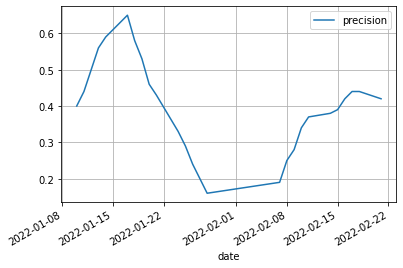

In [139]:
plot_df.rolling(5).mean().plot(grid=True)

In [140]:
from rqdatac import get_price
import rqdatac

rqdatac.init()
hs300_df = get_price(order_book_ids='000300.XSHG', start_date='2022-01-01', end_date='2022-03-22', fields='close')

c:\users\millet\miniconda3\envs\torch1.8-gpu\lib\site-packages\rqdatac\client.py:197: UserWarning: rqdatac is already inited. Settings will be changed.
  warnings.warn("rqdatac is already inited. Settings will be changed.", stacklevel=0)


PermissionDenied: this license is only allowed to access through the education network

In [ ]:
hs300 = hs300_df.reset_index(level='order_book_id').drop(labels='order_book_id', axis=1)
hs300.rolling(5).mean().plot(grid=True)

## 测试模型预测

In [ ]:
import torch
from my_utils.model_class import MLP

model = MLP(in_nums=22, out_nums=2, drop_p=0.5)
model.load_state_dict(torch.load('models/model_c2_p[[0.0, 0.3], [0.7, 1.0]]_b32_lr0.001_d0.5_e500.pth', map_location=para.device))
model = model.to(para.device)

model.eval()
a = model(torch.Tensor([[0.5]*22]*4).to(device=para.device))
a